## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)
*   `n_epochs` de entrenamiento usadas.


El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import torchsummary
import torchmetrics


Por construccion de la ecuación de score , 
aumentando n_layer y test_acc aumenta score 
disminuyendo n_params y n_epochs aumenta score
Por otro lado, veamos el orden de magnitud


In [2]:
#n_epochs=1000
n_epochs = range(100, 4000,1)
print(np.size(n_epochs))
n_params=range(100, 4000,1)
print(np.size(n_params))
test_acc=0.8 #supongamos test accurancy 0.8, 0.9, 0.95
n_leyers=range(100, 4000,1)
print(np.size(n_leyers))
score=[]
a_param=[]
a_epoch=[]
a_leyer=[]
for epoch in n_epochs:
    a_epoch.append(10/epoch)
for param in n_params:
    a_param.append(1/math.log10(param))
#        for leyer in n_leyers:
#            aux_=(1/math.log10(param))*(10/epoch)*test_acc*leyer
#            score.append(aux_)
#score=np.resize(score,200)
print(np.size(a_param))

3900
3900
3900
3900


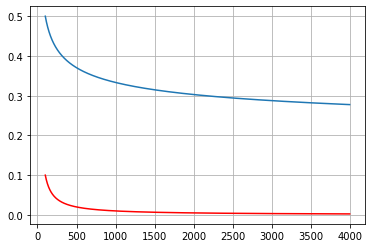

In [3]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
ax.plot(n_leyers, a_param)   
ax.plot(n_leyers, a_epoch,c="r") # podemos ver como la función definida con epoch, converge rapidamente a 0 en unas 4000 iteraciones. 
#Dejaremos la red neuronal con una epoch y veremos los demas parametros. 

ax.grid()

#fig.savefig("test.png")
plt.show()

#### configuramos el `device` acorde al device disponible




In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

1. Cargar base de datos

### Descripción del conjunto de entrenamiento ###
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(28, 28)
### Descripción del conjunto de evaluación ###
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 5
Label de la imágen 1: 0
Label de la imágen 2: 4
Label de la imágen 3: 1
Label de la imágen 4: 9
Label de la imágen 5: 2
Label de la imágen 6: 1
Label de la imágen 7: 3
Label de la imágen 8: 1


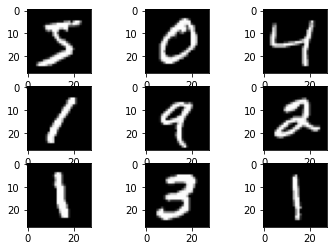

In [5]:
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, label))

plt.show()

In [6]:
import pickle
path="C:/Users/54922/GITHUB/aprendizaje_profundo/clase_5/ejercicios"
X_test = torch.Tensor(np.resize(np.array(pickle.load( open(path+"/test.pkl", "rb" ) )), (7000, 1, 28, 28)))
y_test = torch.Tensor(np.array(pickle.load( open( path+"/test_label.pkl", "rb" ) )))
y_test = y_test.type(torch.LongTensor)
X_train = torch.Tensor(np.resize(np.array(pickle.load( open( path+"/train.pkl", "rb" ) )), (56000, 1, 28, 28)))
y_train = torch.Tensor(np.array(pickle.load( open(path+"/train_label.pkl", "rb" ))) )
y_train = y_train.type(torch.LongTensor)
X_val = torch.Tensor(np.resize(np.array(pickle.load( open( path+"/val.pkl", "rb" ) )), (7000, 1, 28, 28)))
y_val = torch.Tensor(np.array(pickle.load( open(path+"/val_label.pkl", "rb" ))) )
y_val = y_val.type(torch.LongTensor)
print('X_train: ',X_train.shape, ' y_train: ',y_train.shape)
print('X_test: ',X_test.shape, ' y_test: ',y_test.shape)
print('X_val: ',X_val.shape, ' y_val: ',y_val.shape)

X_train:  torch.Size([56000, 1, 28, 28])  y_train:  torch.Size([56000])
X_test:  torch.Size([7000, 1, 28, 28])  y_test:  torch.Size([7000])
X_val:  torch.Size([7000, 1, 28, 28])  y_val:  torch.Size([7000])


In [7]:

from torch.utils.data import DataLoader, TensorDataset
#norm con mean y std
norm=torchvision.transforms.Compose([torchvision.transforms.Normalize(np.mean(np.array(pickle.load( open( path+"/test.pkl", "rb" ) ))),np.std(np.array(pickle.load( open( path+"/test.pkl", "rb" ) ))))])
train_dataset = TensorDataset(norm(X_train),y_train) 
test_dataset = TensorDataset(norm(X_test),y_test) 
val_dataset = TensorDataset(norm(X_val),y_val) 

dataloader = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True,),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
}

# Verificamos 
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Tamaño del batch de feature (input / imagen): torch.Size([32, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([32])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


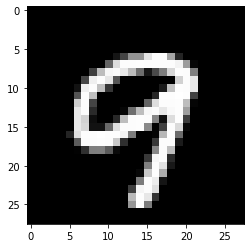

Label: 9


In [8]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

3. Construyo mi CNN

In [88]:
# defino primero un "bloque" de una capa CNN
# construido con los bloques funcionales vistos en clase
#
# (hiper)parámetros a pasar a la función:
#   c_in:   canales (kernels) de entrada
#   c_out:  canales (kernels) de salida
#   k:      tamaño del kernel kxk  ## de kernel de convolución?
#   p:      tamaño del padding de la convolución
#   s:      stride de la convolución
#   pk:     tamaño del kernel del pooling
#   ps:     stride de la pooling
#   pp:     padding en la pooling
#
#   la función pooling se elige directamente dentro del bloque!

def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


# ahora SI construyo mi red... usando la clase CNN de pytorch
# revisar muy bien las dimensiones a emplear en cada capa y
# tener presente la reducción de las dimensiones.
#
# en la útlima capa fully conected 'fc', hacer bien el cálculo final del
# tamaño del array que se obtiene siguiendo la formula vista en la teoria
# tanto para la capa conv como para la capa pooling.
#
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None
    self.conv2 = block(64, 32)
    self.conv2_out = None
    self.conv3 = block(32, 16)
    self.conv3_out = None
    self.conv4 = block(16, 16)
    self.conv4_out = None
    self.conv5 = block(16, 32)
    self.conv5_out = None
    self.conv6 = block(32, 64)
    self.conv6_out = None
    #self.conv7 = block(32, 32)
    #self.conv7_out = None
    #self.conv8 = block(32, 32)
    #self.conv8_out = None
    #self.conv9 = block(32, 32)
    #self.conv9_out = None
    #self.conv10 = block(32, 32)
    #self.conv10_out = None
    #self.conv11 = block(32, 32)
    #self.conv11_out = None
    #self.conv12 = block(32, 32)
    #self.conv12_out = None
    #self.conv13 = block(32, 32)
    #self.conv13_out = None
    self.fc = torch.nn.Linear(32*7*7, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    #self.conv7_out = self.conv7(self.conv6_out)
    #self.conv8_out = self.conv8(self.conv7_out)
    #self.conv9_out = self.conv9(self.conv8_out)
    #self.conv10_out = self.conv10(self.conv9_out)
    #self.conv11_out = self.conv11(self.conv10_out)
    #self.conv12_out = self.conv12(self.conv11_out)
    #self.conv13_out = self.conv13(self.conv12_out)
    y = self.conv2_out.view(self.conv2_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [89]:
model=CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, paddi

In [90]:
from tqdm import tqdm # <- para graficar la barra de avance
epoch=1

def fit(model, dataloader, epochs=epoch):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
        

In [92]:
fit(model, dataloader)

val_loss 0.06040 val_acc 0.98097: 100%|██████████| 219/219 [00:04<00:00, 47.62it/s]

Epoch 1/1 loss 0.08531 val_loss 0.06040 acc 0.97448 val_acc 0.98097


#### Score final (en este caso val_acc es el resultado de evaluación de test dataset)

In [93]:
 epoch=1 #dejar asi
 leyer=8 #aumentar cantidad
 param=64874 #bajar cantidad
 test_acc=0.981
 (1/math.log10(param))*(10/epoch)*test_acc*leyer

16.30898739364444